# # Заняття 9

## Мета:
Розробити та налаштувати GAN для задачі відновлення зображень (наприклад, збільшення роздільної здатності, відновлення пошкоджених зображень), а також оцінити ефективність отриманої моделі.

---

## Кроки для виконання завдання:

### 1. Встановлення середовища:
- Встановіть необхідні бібліотеки: TensorFlow або PyTorch, numpy, matplotlib, OpenCV (для обробки зображень).
- Підготуйте обчислювальне середовище із GPU для швидшого навчання, якщо можливо.

---

### 2. Вибір та підготовка набору даних:
- Виберіть набір даних для відновлення зображень, наприклад, CelebA (для облич) або інший датасет зображень.
- Підготуйте навчальні приклади: створіть зменшені або пошкоджені версії зображень для тренування GAN (наприклад, зменшення роздільної здатності, розмиття або додавання шуму).

---

### 3. Створення архітектури GAN для відновлення зображень:
#### Генератор:
- Побудуйте генератор, що прийматиме зображення з низькою роздільною здатністю (або пошкоджене) та відновлюватиме його до високоякісної версії.
  - Використайте згорткові шари (Conv2DTranspose) та шари Batch Normalization для кращої стабільності.
  - Додайте функцію активації ReLU або LeakyReLU в прихованих шарах, і tanh для вихідного шару.

#### Дискримінатор:
- Побудуйте дискримінатор для розпізнавання відновлених (штучних) зображень від реальних.
  - Використайте згорткові шари з функціями активації LeakyReLU та нормалізацію пакетів (Batch Normalization).
  - Завершіть дискримінатор функцією активації sigmoid для класифікації (реальне/згенероване).

---

### 4. Налаштування функцій втрат та оптимізаторів:
- Використайте binary cross-entropy як функцію втрат для дискримінатора.
- Для генератора використайте mean squared error або L1 втрати для відновлення зображення та повний adversarial loss (для конкуренції з дискримінатором).
- Налаштуйте оптимізатори (наприклад, Adam) з відповідними коефіцієнтами навчання (зазвичай, менший коефіцієнт для дискримінатора).

---

### 5. Навчання GAN:
- **Крок 1:** Навчіть дискримінатор окремо, використовуючи реальні та згенеровані зображення.
- **Крок 2:** Навчіть генератор для покращення якості зображень і обману дискримінатора.
- Повторюйте цей процес навчання протягом декількох епох, поступово збільшуючи якість згенерованих зображень.

---

### 6. Оцінка ефективності:
- Використайте метрики, такі як PSNR (Peak Signal-to-Noise Ratio) та SSIM (Structural Similarity Index) для оцінки якості відновлених зображень.
- Проведіть візуальне порівняння між відновленими зображеннями та оригіналами для оцінки точності відновлення.

---

## Мінімальні вимоги:
- Реалізувати GAN для відновлення зображень та провести базову оцінку ефективності за допомогою метрик PSNR та SSIM.

---

## Додаткові рекомендації:
- Спробуйте інші архітектури GAN, такі як SRGAN (Super-Resolution GAN) для покращення якості відновлення зображень.

---

## Формат виконання:
- `.ipynb` блокнот із кодом та візуалізацією, або ж код в `.py` з прикріпленими зображеннями результатів на гітхабі.


### 1. Встановлення середовища:

In [43]:
%pip install torch torchvision matplotlib gdown

Note: you may need to restart the kernel to use updated packages.


In [44]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

### 2. Вибір та підготовка набору даних:

In [45]:

# Шлях для збереження датасету
dataset_path = "./data/celeba"

# Перетворення для попередньої обробки зображень
transform = transforms.Compose(
    [
        transforms.CenterCrop(178),  # Обрізання до центральної області
        transforms.Resize(128),  # Зміна розміру зображення до 128x128
        transforms.ToTensor(),  # Перетворення зображення в тензор
        transforms.Normalize(
            mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]
        ),  # Нормалізація до [-1, 1]
    ]
)

# Завантаження датасету CelebA
celeba_dataset = datasets.CelebA(
    root=dataset_path,
    split="train",  # Або "valid", "test"
    transform=transform,
    download=True,  # Автоматично завантажить датасет, якщо його ще немає
)

# DataLoader для зручності роботи
batch_size = 64
celeba_loader = DataLoader(celeba_dataset, batch_size=batch_size, shuffle=True)

# Перевірка
print(f"Кількість зображень у датасеті: {len(celeba_dataset)}")

Files already downloaded and verified
Кількість зображень у датасеті: 162770


#### Підготовка пошкоджених версій зображень

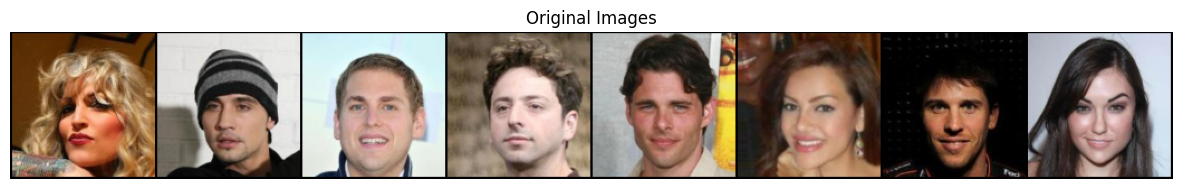

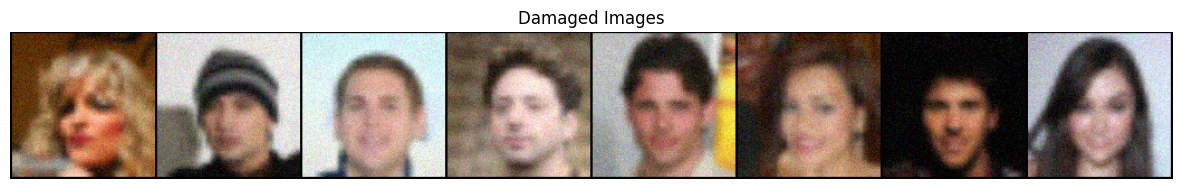

In [46]:
import torch
import torchvision
import torchvision.transforms.functional as F
import random


def create_damaged_images(batch):
    """
    Функція для створення пошкоджених зображень.
    Зменшуємо роздільну здатність і додаємо шум.
    """
    # Зменшення роздільної здатності
    low_res = F.resize(batch, size=(32, 32))  # Зменшення до 32x32
    damaged = F.resize(low_res, size=(128, 128))  # Повернення до 128x128

    # Додавання шуму
    noise = torch.randn_like(damaged) * 0.1  # Невеликий випадковий шум
    damaged += noise

    return torch.clamp(damaged, -1, 1)  # Обрізаємо значення до діапазону [-1, 1]


# Перевіримо на одному батчі
data_iter = iter(celeba_loader)
real_images, _ = next(data_iter)  # Отримуємо реальні зображення
damaged_images = create_damaged_images(real_images)

# Візуалізуємо реальні та пошкоджені зображення
import matplotlib.pyplot as plt


def show_images(images, title):
    grid = torchvision.utils.make_grid(images[:8], normalize=True, value_range=(-1, 1))
    plt.figure(figsize=(15, 5))
    plt.title(title)
    plt.imshow(grid.permute(1, 2, 0))
    plt.axis("off")
    plt.show()


show_images(real_images, "Original Images")
show_images(damaged_images, "Damaged Images")

### 3. Створення архітектури GAN для відновлення зображень:

#### Генератор
Генератор приймає пошкоджені зображення і відновлює їх.

In [47]:
import torch.nn as nn


class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 3, kernel_size=3, stride=1, padding=1),
            nn.Tanh(),  # Для відновлення зображення в діапазоні [-1, 1]
        )

    def forward(self, x):
        return self.model(x)

#### Дискримінатор
Дискримінатор навчається розпізнавати реальні зображення від згенерованих.

In [48]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Flatten(),
            nn.Linear(128 * 32 * 32, 1),
            nn.Sigmoid(),  # Ймовірність реального зображення
        )

    def forward(self, x):
        return self.model(x)

### 4. Налаштування функцій втрат та оптимізаторів:


In [49]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Ініціалізація моделей
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Оптимізатори
lr = 0.0002
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

# Функції втрат
adversarial_loss = nn.BCELoss()
pixelwise_loss = nn.L1Loss()

### 5. Навчання GAN:

In [50]:
import torch
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt
import torchvision


class Trainer:
    def __init__(
        self,
        generator,
        discriminator,
        optimizer_G,
        optimizer_D,
        adversarial_loss,
        pixelwise_loss,
        device="cpu",
    ):
        self.generator = generator.to(device)
        self.discriminator = discriminator.to(device)
        self.optimizer_G = optimizer_G
        self.optimizer_D = optimizer_D
        self.adversarial_loss = adversarial_loss
        self.pixelwise_loss = pixelwise_loss
        self.device = device

    def train(self, dataloader, epochs, save_interval=5, display_interval=1):
        for epoch in range(epochs):
            epoch_loss_G = 0
            epoch_loss_D = 0

            for real_images, _ in tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}"):
                real_images = real_images.to(self.device)

                # Створення пошкоджених зображень
                damaged_images = self.create_damaged_images(real_images)

                # ====================
                # Навчання дискримінатора
                # ====================
                self.optimizer_D.zero_grad()

                # Реальні зображення
                real_labels = torch.ones((real_images.size(0), 1), device=self.device)
                fake_labels = torch.zeros((real_images.size(0), 1), device=self.device)

                real_preds = self.discriminator(real_images)
                real_loss = self.adversarial_loss(real_preds, real_labels)

                # Згенеровані зображення
                fake_images = self.generator(damaged_images).detach()
                fake_preds = self.discriminator(fake_images)
                fake_loss = self.adversarial_loss(fake_preds, fake_labels)

                # Загальний loss дискримінатора
                loss_D = (real_loss + fake_loss) / 2
                loss_D.backward()
                self.optimizer_D.step()

                # ====================
                # Навчання генератора
                # ====================
                self.optimizer_G.zero_grad()

                fake_images = self.generator(damaged_images)
                fake_preds = self.discriminator(fake_images)

                # Adversarial loss
                loss_G_adv = self.adversarial_loss(fake_preds, real_labels)

                # Pixel-wise loss (наприклад, L1)
                loss_G_pixel = self.pixelwise_loss(fake_images, real_images)

                # Загальний loss генератора
                loss_G = loss_G_adv + 100 * loss_G_pixel
                loss_G.backward()
                self.optimizer_G.step()

                # Підрахунок втрат за епоху
                epoch_loss_G += loss_G.item()
                epoch_loss_D += loss_D.item()

            print(
                f"Epoch [{epoch+1}/{epochs}] - Loss G: {epoch_loss_G / len(dataloader):.4f}, Loss D: {epoch_loss_D / len(dataloader):.4f}"
            )

            # Візуалізація результатів
            if (epoch + 1) % display_interval == 0:
                self.display_results(
                    real_images, damaged_images, fake_images, epoch + 1
                )

            # Збереження моделей
            if (epoch + 1) % save_interval == 0:
                self.save_models(epoch + 1)

    def create_damaged_images(self, batch):
        """
        Функція для створення пошкоджених зображень (низька роздільна здатність + шум).
        """
        low_res = nn.functional.interpolate(batch, size=(32, 32), mode="bilinear")
        damaged = nn.functional.interpolate(low_res, size=(128, 128), mode="bilinear")
        noise = torch.randn_like(damaged) * 0.1
        return torch.clamp(damaged + noise, -1, 1)

    def display_results(self, real_images, damaged_images, fake_images, epoch):
        """
        Візуалізація реальних, пошкоджених та відновлених зображень.
        """
        real_grid = torchvision.utils.make_grid(
            real_images[:8], normalize=True, value_range=(-1, 1)
        )
        damaged_grid = torchvision.utils.make_grid(
            damaged_images[:8], normalize=True, value_range=(-1, 1)
        )
        fake_grid = torchvision.utils.make_grid(
            fake_images[:8], normalize=True, value_range=(-1, 1)
        )

        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.title("Real Images")
        plt.imshow(real_grid.permute(1, 2, 0).cpu().numpy())
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.title("Damaged Images")
        plt.imshow(damaged_grid.permute(1, 2, 0).cpu().numpy())
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.title("Generated Images")
        plt.imshow(fake_grid.permute(1, 2, 0).cpu().numpy())
        plt.axis("off")

        plt.show()

    def save_models(self, epoch):
        """Збереження моделей генератора та дискримінатора"""
        torch.save(self.generator.state_dict(), f"generator_epoch_{epoch}.pth")
        torch.save(self.discriminator.state_dict(), f"discriminator_epoch_{epoch}.pth")
        print(f"Models saved for epoch {epoch}")

In [51]:
# Параметри навчання
epochs = 20
save_interval = 5
display_interval = 2

# Ініціалізація тренера
trainer = Trainer(
    generator=generator,
    discriminator=discriminator,
    optimizer_G=optimizer_G,
    optimizer_D=optimizer_D,
    adversarial_loss=adversarial_loss,
    pixelwise_loss=pixelwise_loss,
    device=device,
)

# Запуск навчання
trainer.train(
    dataloader=celeba_loader,
    epochs=epochs,
    save_interval=save_interval,
    display_interval=display_interval,
)

Epoch 1/20:   0%|          | 6/2544 [01:05<7:38:44, 10.85s/it]


KeyboardInterrupt: 